In [405]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [406]:
#from google.colab import drive
#drive.mount('/content/drive')

In [407]:
def load_data(L,temp,MCS):
    return np.fromfile(f"../ising_wolff/dataIsing2D_L{L}/config_L{L}_T{temp:.3f}.bin",dtype = np.int32).reshape(MCS,L**2)
#def load_data(L,temp,MCS):
#    return np.fromfile(f"/content/drive/MyDrive/ising_data/dataIsing2D_L10/config_L{L}_T{temp:.3f}.bin",dtype = np.int32).reshape(MCS,L**2)

In [437]:
Tmin = 2.27
Tmax = 3.22
meas = 20
Ts = np.linspace(Tmin,Tmax,meas)
L = 8
#data = load_data(L,Ts[9],200000)
data = load_data(L,Ts[18],200000)
Ts[18]

3.17

$\mathbf{A} = \mathbf{W} + g\left[\mathbf{M}\mathbf{W}-\mathbf{1} \right]$


$\mathbf{W} = \left(\Delta_t \mathbf{1} + \mathbf{C}^0 e^{-2t}\right)^{-1}$

$\mathbf{M} = 3\Delta_t(\Delta_t + e^{-2t} ) \mathbf{1} +(3\Delta_t+e^{-2t})\mathbf{C}^0 e^{-2t} $

The equation for $g$ is:

$\text{Tr}(\mathbf{A}(\mathbf{M}-\mathbf{W}^{-1})) - g \cdot\text{Tr}(x_i^2  (x_i^2-1)^2) + \cdots$ = 0

Let's get the matrix M and W

In [410]:
N =L**2
nSteps =300
dt = 0.02
diffTemp = 2
def Deltat(n,dt,diffTemp):
    return diffTemp*(1-np.exp(-2*(n+1)*dt))

In [411]:
C0 = np.cov(data.T)
W = np.empty((nSteps,N,N))
invW = np.empty((nSteps,N,N))
M = np.empty((nSteps,N,N))
K = np.empty((nSteps,N,N))
M = np.empty((nSteps,N,N))

In [412]:
for t in range(nSteps):
    Dt = Deltat(t,dt,diffTemp)
    exp2t=np.exp(-2*(t+1)*dt)
    invW[t] = Dt*np.eye(N) + C0*exp2t
    W[t] = np.linalg.inv(invW[t])
    M[t] = (3*Dt+exp2t)*C0*exp2t+ 3*Dt*(Dt + exp2t)*np.eye(N)

$\mathbf{A}(\mathbf{M}-\mathbf{W}^{-1}) = \mathbf{W}\mathbf{M} - \mathbf{1} + g\cdot (-2\mathbf{M} + \mathbf{W}^{-1} + \mathbf{M}\mathbf{W}\mathbf{M}) = \mathbf{K} + g\cdot \mathbf{K_g}$

$ \mathbf{K} + g\cdot \mathbf{K_g} - g\cdot \mathbf{C}_6  - \mathbf{C_4} = 0$

In [413]:
K = np.matmul(W,M) - np.eye(W.shape[1])
K_g = -2*M + invW + np.matmul(M,np.matmul(W,M))

Now the other terms

In [414]:
ts= np.array([*range(nSteps)])
Dts = Deltat(ts,dt,diffTemp)
expts = np.exp(-2*(ts+1)*dt)
C6 = Dts*(15*Dts**2 - 6*Dts + 1) + expts *(45*Dts**2 - 12*Dts + 1) + expts**2 * (15*Dts-2) + expts**3
C4 = 3*(Dts+expts)-1

$g = -\frac{\text{Tr}(\mathbf{K}) - \mathbf{C}_4}{\text{Tr}(\mathbf{K}_g) - \mathbf{C}_6}$

In [415]:
num = np.trace(K,axis1=1,axis2=2) - N*C4
den = np.trace(K_g,axis1=1,axis2=2) - N*C6
g = -num/den

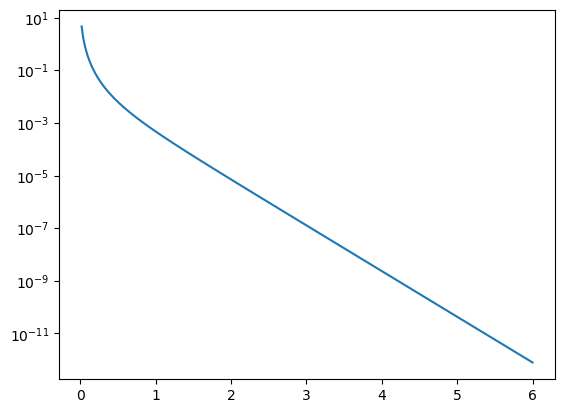

In [416]:
plt.plot((ts+1)*dt,-g)
plt.yscale("log")
#plt.xscale("log")
#plt.axvline(dt*2)

$\mathbf{A} = \mathbf{W} + g\left[\mathbf{M}\mathbf{W}-\mathbf{1} \right]$


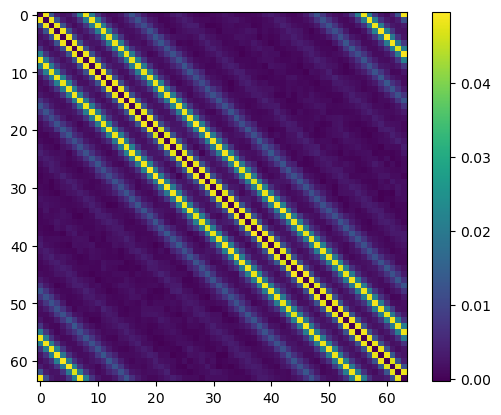

In [444]:
#MW = g.reshape(nSteps,1,1)*(np.matmul(M,W)-np.eye(N).reshape(1,N,N))
A =  W + g.reshape(nSteps,1,1)*(np.matmul(M,W)-np.eye(N).reshape(1,N,N))
#A = W
#plt.imshow(MW[0]-np.diag(np.diag(MW[0])))
plt.imshow(-A[20]+np.diag(np.diag(A[20])))
plt.colorbar()

In [429]:
def myscore(x,A,g,device = "cuda"):
    return  -torch.matmul(x,A.T) + g*x*(x**2-1)

In [430]:
def backward(xT,A,g,temp,nSteps,dt,full_traj = False,device = "cuda"):
    P = xT.shape[0]
    N = xT.shape[1]
    A =torch.from_numpy(A).to(device).to(torch.float32)
    g =torch.from_numpy(g).to(device).to(torch.float32)
    nbatches = 100
    batch_size = int(P/nbatches)
    if(full_traj):
        x_recon = torch.Tensor(P,nSteps+1,N).to(device)
        x_recon[:,-1,:] = xT.to(device)
    else:
        x_recon = xT.to(device)
    with torch.no_grad():
        for tt in range(1,nSteps+1)[::-1]:
            std = np.sqrt(2*temp*dt)*torch.randn_like(xT).to(device)
            if tt==1:
                std = torch.zeros(xT.shape)

            for n in range(nbatches):
                if(full_traj):
                    score = myscore(x_recon[n*batch_size:(n+1)*batch_size,tt,:], A[tt-1],g[tt-1],device)
                    x_recon[n*batch_size:(n+1)*batch_size,tt-1,:] = x_recon[n*batch_size:(n+1)*batch_size,tt,:]*(1+dt) + 2*temp*score*dt + std[n*batch_size:(n+1)*batch_size]
                else:
                    score = myscore(x_recon[n*batch_size:(n+1)*batch_size], A[tt-1],g[tt-1],device)
                    x_recon[n*batch_size:(n+1)*batch_size] = x_recon[n*batch_size:(n+1)*batch_size]*(1+dt)+ 2*temp*score*dt + std[n*batch_size:(n+1)*batch_size]
                del score

    return x_recon.to("cpu").numpy()

In [431]:
P = 100000
N = L**2
xT = np.sqrt(diffTemp)*torch.randn((P,N))
x_recon = backward(xT,A,g,diffTemp,nSteps,dt,device= "cpu")

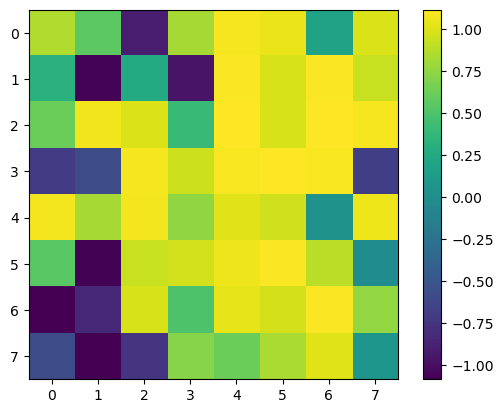

In [432]:
plt.imshow(x_recon[0].reshape(L,L))
plt.colorbar()

(array([0.03125 , 0.204925, 0.574075, 0.733475, 0.8688  , 1.028125,
        0.745325, 0.577975, 0.2036  , 0.03245 ]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

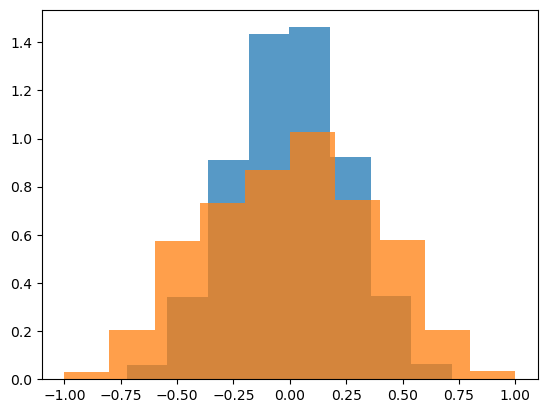

In [433]:
plt.hist(np.mean(x_recon,axis = 1),density=True,alpha = 0.75)
plt.hist(np.mean(data,axis = 1),density=True,alpha = 0.75)

(array([2.0000e+00, 1.7820e+04, 1.3835e+04, 6.7120e+03, 4.7690e+03,
        4.0630e+03, 3.8260e+03, 4.1120e+03, 4.5060e+03, 6.0270e+03,
        1.0405e+04, 2.3921e+04, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00]),
 array([-1.45436382, -1.23590994, -1.01745617, -0.79900229, -0.58054847,
        -0.36209464, -0.14364079,  0.07481305,  0.29326689,  0.51172072,
         0.73017454,  0.94862843,  1.16708219,  1.38553607,  1.60398996,
         1.82244372,  2.04089761,  2.25935149,  2.47780538,  2.69625902,
         2.91471291,  3.13316679]),
 <BarContainer object of 21 artists>)

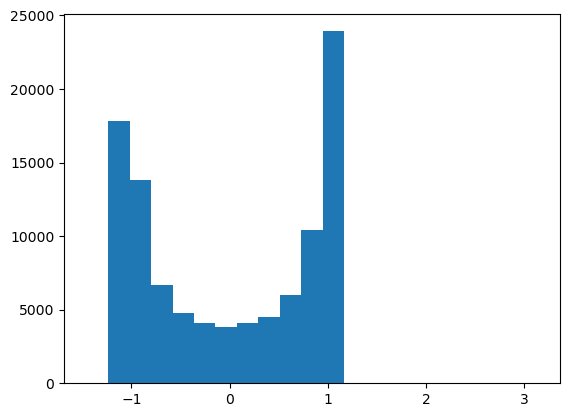

In [434]:
plt.hist(x_recon[:,0],bins = 21)

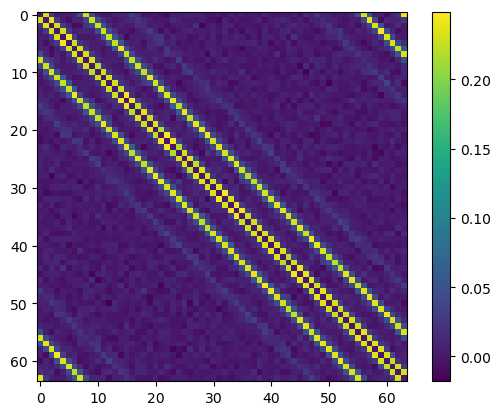

In [435]:
Jrecon = np.linalg.inv(np.cov(x_recon.T))
Jrecon = -Jrecon +np.diag(np.diag(Jrecon))
plt.imshow(Jrecon)
plt.colorbar()

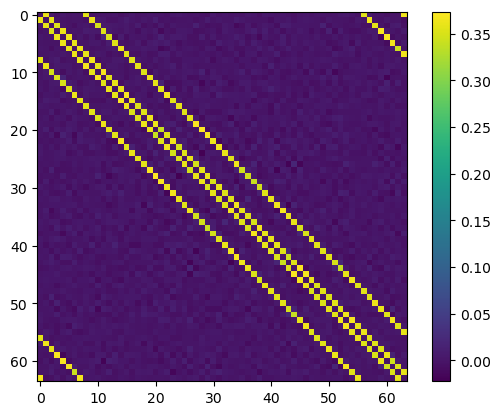

In [436]:
Jtrue = np.linalg.inv(np.cov(data.T))
#Jtrue = (np.cov(data.T))
Jtrue = -Jtrue +np.diag(np.diag(Jtrue))
plt.imshow(Jtrue)
plt.colorbar()